Author: Nicolas Legrand <nicolas.legrand@cfin.au.dk>

In [175]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
from scipy.stats import ttest_1samp
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from systole.detection import oxi_peaks, rr_artefacts
from systole.correction import correct_peaks
from systole.utils import heart_rate, to_epochs
from mne.stats import permutation_cluster_test

In [176]:
path = os.path.join(os.getcwd(), 'data', 'task')
subjects = [f for f in os.listdir(path) if len(f) == 5]
filename = path + '/{nSub}/{nSub}_Aro_{arousal}_Val_{valence}_Learn_{learningTime}_Block_{block}.txt'  # Template for signal files

In [177]:
# For bad signal
reject = ['11141', '11137']

In [178]:
subjects = [f for f in subjects if f not in reject]

# Regression

In [208]:
def extract_epochs(signal, triggers, valence, arousal, learningTime, nSub, tmin, tmax,
                   draw_figure=False, figure_name=None):
    """This function will find peaks in signal, reject artefacts and epoch the raw data.
    If draw_figure is True, will also create a report figure."""

    # Find peaks
    signal, peaks = oxi_peaks(signal, noise_removal=False)
    
    # Correct extra and missed peaks
    peaks_correction = correct_peaks(peaks)
    peaks = peaks_correction['clean_peaks']

    # Extract instantaneous heartrate
    hr, time = heart_rate(peaks, sfreq=1000, unit='bpm', kind='previous')
    hr = gaussian_filter1d(hr, sigma=100)

    # Interpolate HR to 75 Hz
    f = interp1d(time, hr, fill_value="extrapolate")
    new_time = np.arange(0, time[-1], 1/75)
    hr = f(new_time)

    # Outliers detection
    artefacts = rr_artefacts(np.diff(np.where(peaks)[0]))
    outliers = artefacts['ectopic'] | artefacts['short'] | artefacts['long'] | artefacts['extra'] | artefacts['missed']
        
    # Create bads vector
    reject = np.zeros(len(peaks))
    for i in np.where(outliers)[0]:
        reject[np.where(peaks)[0][i-1]:np.where(peaks)[0][i+1]] = 1
        
    # Interpolate HR to 75 Hz
    f = interp1d(time, reject, fill_value="extrapolate")
    new_time = np.arange(0, time[-1], 1/75)
    reject = f(new_time)

     # Epoching
    epoch = to_epochs(hr, triggers, sfreq=75, event_val=2, tmin=tmin, tmax=tmax, apply_baseline=(-1, 0), reject=reject)
    
    if draw_figure:
        plot_epochs(epoch=epoch, triggers=triggers, peaks=peaks, time=time, new_time=new_time, hr=hr,
                   outliers=outliers, figure_name=figure_name)

    return epoch

In [209]:
tmin, tmax = -1, 6
final_df = pd.DataFrame([])
for nSub in subjects:
    
    # Import behavioural data
    df = pd.read_csv(os.path.join(path, nSub, 'Subject_{}.txt'.format(nSub)), na_values=['Nan'])

    # Loop through conditions
    for val in ['High', 'Low']:
        
        for aro in ['High', 'Low']:
            
            X, y = None, np.array([])

            for learningTime in [30, 60, 90]:
                
                # Filter for condition
                this_df = df.copy()[(df.Arousal == aro) & (df.Valence == val) & (df.LearningTime == learningTime)]
                nBlock = this_df.nBlock.iloc[0]  # Get block numbers                

                # Remove NaN, fast and slow RT
                drop = ((this_df.RT.isnull() | this_df.Confidence.isnull()) | 
                        (this_df.RT < .1) | (this_df.RT > (this_df.RT.median() + (3 * this_df.RT.std()))))                
                
                # Import pulse oximeter recording
                signal_file = filename.format(nSub=nSub, arousal=aro, valence=val, learningTime=learningTime, block=int(nBlock))
                signal_df = pd.read_csv(signal_file)

                # Extract epoch and plot artefact rejection
                epoch = extract_epochs(signal_df.signal.to_numpy(),
                                       signal_df.triggers.to_numpy(),
                                       valence=val, arousal=aro, learningTime=learningTime, nSub=nSub,
                                       tmin=tmin, tmax=tmax)
            
                # Drop no response and artefact trials
                drop = drop | np.isnan(epoch.mean(axis=1))
                epoch = epoch[~drop, :]

                # Store data for linear regression
                y = np.append(y, this_df.Confidence.to_numpy()[~drop])
                if X is not None:
                    X = np.concatenate([X, epoch])
                else:
                    X = epoch

            # Fit linear regression to predict Confidence
            std_clf = make_pipeline(StandardScaler(), LinearRegression())

            beta = []
            for i in range(X.shape[1]):
                reg = std_clf.fit(y.reshape(-1, 1), X[:, i].reshape(-1, 1))
                beta.append(reg.named_steps['linearregression'].coef_[0][0])

            final_df = final_df.append(pd.DataFrame({'Valence': val,
                                                     'Arousal': aro,
                                                     'LearningTime': learningTime,
                                                     'Time': np.arange(tmin, tmax, 1/75),
                                                     'Subject': nSub,
                                                     'Beta': np.asarray(beta)}))

# Plots

## Valence

stat_fun(H1): min=0.000046 max=7.876467
Running initial clustering
Found 1 clusters
Permuting 999 times...
[............................................................] 100.00%  |
Computing cluster p-values
Done.


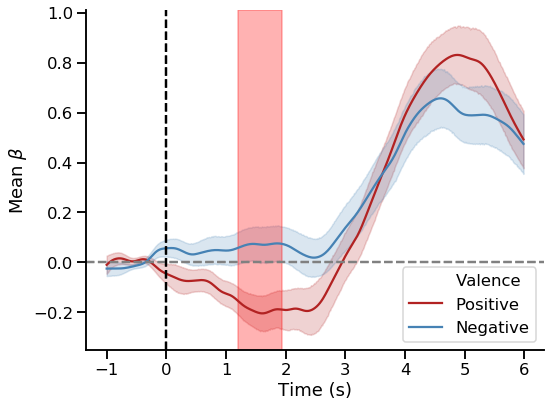

In [219]:
sns.set_context('talk')
plt.figure(figsize=(8, 6))

df = final_df.copy().groupby(['Subject', 'Valence', 'Time'], as_index=False).mean()
df.Valence = df.Valence.replace(['Low', 'High'], ['Negative', 'Positive'])

data = []
for val in ['Negative', 'Positive']:
    data.append(df[(df['Valence']==val)].pivot(index='Time',columns='Subject')['Beta'].to_numpy())
data = np.asarray(data)

T_obs, clusters, cluster_p_values, H0 = \
    permutation_cluster_test([data[0].T, data[1].T],
                             n_permutations=1000, threshold=6)

times = np.arange(-1, 6, 1/75)
for i, c in enumerate(clusters):
    if cluster_p_values[i] <= 0.05:
        c = c[0]
        plt.axvspan(times[c.start], times[c.stop - 1],
                            color='r', alpha=0.3)
    
sns.lineplot(data=df, x='Time', y='Beta', hue='Valence', ci=68, n_boot=10000, palette=['firebrick', 'steelblue'])

plt.axhline(y=0, linestyle='--', color='gray')
plt.axvline(x=0, linestyle='--', color='k')
plt.ylabel(r'Mean $\beta$')
plt.xlabel('Time (s)')
plt.axhline(y=0, linestyle='--', color='gray')
plt.axvline(x=0, linestyle='--', color='k')
sns.despine()
plt.tight_layout()

dirName = os.path.join(os.getcwd(), 'Figures/')
plt.savefig(dirName + '/Valence - Beta.svg', dpi=300)

In [221]:
cluster_p_values, clusters

(array([], dtype=float64), array([], dtype=float64))

## Arousal

stat_fun(H1): min=0.000000 max=1.898343
Running initial clustering
Found 0 clusters


<ipython-input-220-b5a02d945d26>:13: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  n_permutations=1000, threshold=6)


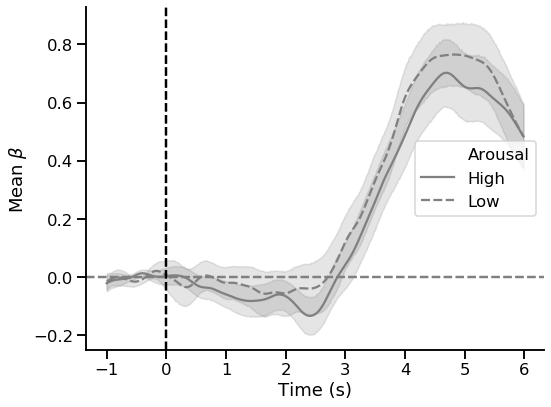

In [220]:
sns.set_context('talk')
plt.figure(figsize=(8, 6))

df = final_df.copy().groupby(['Subject', 'Arousal', 'Time'], as_index=False).mean()

data = []
for val in ['High', 'Low']:
    data.append(df[(df['Arousal']==val)].pivot(index='Time',columns='Subject')['Beta'].to_numpy())
data = np.asarray(data)

T_obs, clusters, cluster_p_values, H0 = \
    permutation_cluster_test([data[0].T, data[1].T],
                             n_permutations=1000, threshold=6)

times = np.arange(-1, 6, 1/75)
for c in clusters:
    c = c[0]
    plt.axvspan(times[c.start], times[c.stop - 1],
                        color='r', alpha=0.3)
    
sns.lineplot(data=df, x='Time', y='Beta', hue='Arousal', style='Arousal', ci=68, n_boot=10000, palette=['gray', 'gray'])

plt.axhline(y=0, linestyle='--', color='gray')
plt.axvline(x=0, linestyle='--', color='k')
plt.ylabel(r'Mean $\beta$')
plt.xlabel('Time (s)')
plt.axhline(y=0, linestyle='--', color='gray')
plt.axvline(x=0, linestyle='--', color='k')
sns.despine()
plt.tight_layout()

dirName = os.path.join(os.getcwd(), 'Figures/')
plt.savefig(dirName + '/Arousal - Beta.svg', dpi=300)